In [1]:
import sys
import os
sys.path.append(os.path.abspath('../src'))
sys.path.append(os.path.abspath('../Dataset'))
sys.path.append(os.path.abspath('..'))

import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from func_preprocesamiento import preprocesar, preprocesar_binarios, procesar_antiguedad, preprocesar_categoricos

In [2]:
dev_df = pd.read_csv('../Dataset/raw/dev.csv')
bins = pd.qcut(dev_df['precio_pesos_constantes'], q=5, labels=False)  # 4 cuartiles
train_dataset, val_dataset = train_test_split(dev_df, train_size=0.8, random_state=42, stratify=bins)

/tmp/ipykernel_32057/1655610193.py:1: DtypeWarning: Columns (8,33) have mixed types. Specify dtype option on import or set low_memory=False.
  dev_df = pd.read_csv('../Dataset/raw/dev.csv')


In [ ]:
train_procesado = preprocesar(train_dataset)
direccion = '../Dataset/Procesado/train_procesado.csv'
train_procesado.to_csv(direccion, index=False)
train_procesado_categorico = pd.read_csv(direccion)

Columna a predecir: ITE_ADD_NEIGHBORHOOD_NAME_encoded
Columna a predecir: SalonDeUsosMul
Columna a predecir: AireAC
Columna a predecir: Estacionamiento
Columna a predecir: Seguridad
Columna a predecir: AreaParrillas
Columna a predecir: CanchaTennis
Columna a predecir: AreaCine
Columna a predecir: Gimnasio
Columna a predecir: Amoblado
Columna a predecir: STotalM2
Columna a predecir: SConstrM2
Columna a predecir: Antiguedad


In [4]:
df_val = preprocesar(val_dataset)
direccion = '../Dataset/Procesado/val_procesado.csv'
df_val.to_csv(direccion, index=False)
val_procesado_categorico = pd.read_csv(direccion)

Columna a predecir: ITE_ADD_NEIGHBORHOOD_NAME_encoded
Columna a predecir: SalonDeUsosMul
Columna a predecir: AireAC
Columna a predecir: Estacionamiento
Columna a predecir: Seguridad
Columna a predecir: AreaParrillas
Columna a predecir: CanchaTennis
Columna a predecir: AreaCine
Columna a predecir: Gimnasio
Columna a predecir: Amoblado
Columna a predecir: STotalM2
Columna a predecir: SConstrM2
Columna a predecir: Antiguedad


## DATASET NUMERICO

In [ ]:
#ARMAMOS EL DATASET NUMERICO SACANDO LAS COLUMNAS CATEGORICAS
columna = ['ITE_ADD_CITY_NAME', 'ITE_ADD_STATE_NAME', 'ITE_ADD_NEIGHBORHOOD_NAME', 'ITE_TIPO_PROD', 'TIPOPROPIEDAD'] #SACARLAS PORQUE SON CATEGORICAS
direccion = '../Dataset/Procesado/train_procesado_numerico.csv'
train_procesado = train_procesado.drop(columns=columna)
train_procesado.to_csv(direccion, index=False)
train_procesado = pd.read_csv(direccion)

direccion = '../Dataset/Procesado/val_procesado_numerico.csv'
df_val = df_val.drop(columns=columna)
df_val.to_csv(direccion, index=False)
val_procesado = pd.read_csv(direccion)

In [97]:
#NUEVOO
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns


direccion = '../Dataset/Procesado/train_procesado_numerico.csv'
train_procesado = pd.read_csv(direccion)
train_procesado = train_procesado[train_procesado['STotalM2'] < 10**3]
train_procesado = train_procesado[train_procesado['STotalM2'] > 10]

# Seleccionar las características a usar
X = train_procesado[['STotalM2', 'Antiguedad', 'precio_pesos_constantes']]


# Configurar y entrenar el modelo Isolation Forest
iso_forest = IsolationForest(contamination=0.009, random_state=42)  # Ajusta contamination según tu criterio
iso_forest.fit(X)

# Predecir los outliers
train_procesado['anomaly_score'] = iso_forest.predict(X)

# Identificar outliers
outliers = train_procesado[train_procesado['anomaly_score'] == -1]


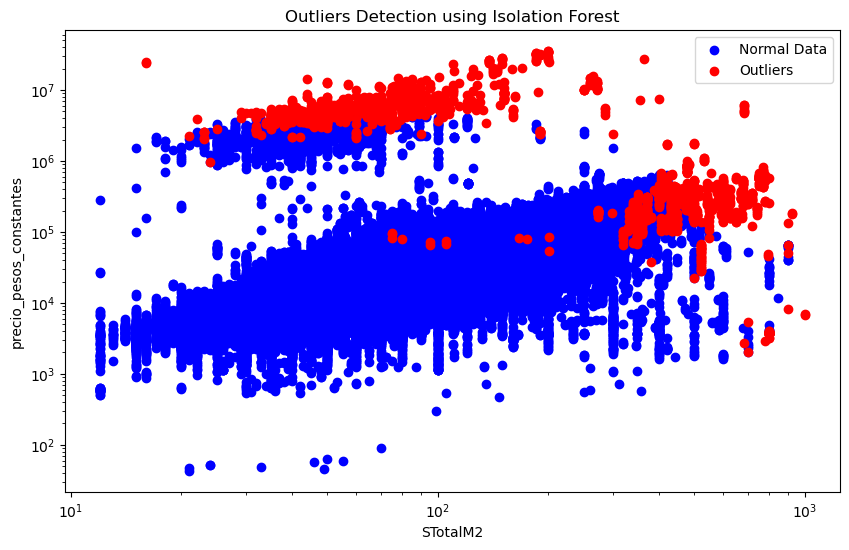

Cantidad de outliers: 1700
Estos son los datos de los outliers:
        STotalM2  Antiguedad  Ambientes  precio_pesos_constantes
4            440          55          5             2.655046e+05
81           800           4          2             3.165347e+03
207           70           0          3             5.752600e+06
277           47          45          2             3.485880e+06
351           80           0          3             5.264707e+06
...          ...         ...        ...                      ...
189155        16           0          4             2.402706e+07
189324       271           0          8             1.096930e+07
189403       611          14          6             4.100801e+05
189452       423          90          6             1.548777e+05
189464       201          40          5             2.510356e+07

[1700 rows x 4 columns]
        STotalM2  Antiguedad  Ambientes  precio_pesos_constantes
29167        200          30          4             3.518759e+07
5

In [98]:
plt.figure(figsize=(10, 6))

# Graficar los puntos normales
plt.scatter(train_procesado[train_procesado['anomaly_score'] == 1]['STotalM2'], 
            train_procesado[train_procesado['anomaly_score'] == 1]['precio_pesos_constantes'], 
            color='blue', label='Normal Data')

# Graficar los outliers
plt.scatter(outliers['STotalM2'], outliers['precio_pesos_constantes'], 
            color='red', label='Outliers')

# Agregar etiquetas y leyenda
plt.xlabel('STotalM2')
plt.ylabel('precio_pesos_constantes')
plt.title('Outliers Detection using Isolation Forest')
plt.legend()

# Establecer escala logarítmica
plt.xscale('log')
plt.yscale('log')

plt.show()

print('Cantidad de outliers:', outliers.shape[0])
print('Estos son los datos de los outliers:')
print(outliers[['STotalM2', 'Antiguedad', 'Ambientes', 'precio_pesos_constantes']])


top_10_max_price = train_procesado.nlargest(10, 'precio_pesos_constantes')

# Mostrar los metros cuadrados y el precio de estos registros
print(top_10_max_price[['STotalM2', 'Antiguedad', 'Ambientes', 'precio_pesos_constantes']])

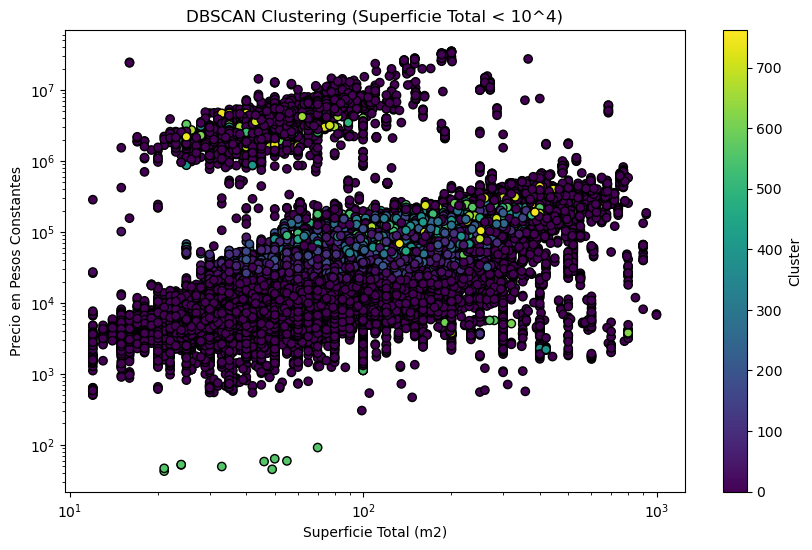

In [99]:
from sklearn.cluster import DBSCAN

# Parámetros óptimos
eps = 50  # Ajusta este valor según el gráfico de k-distancias
min_samples = 5

# Ejecutar DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(X)

# Agregar etiquetas de cluster a los datos
train_procesado['cluster'] = labels

# Graficar los datos filtrados
plt.figure(figsize=(10, 6))
plt.scatter(train_procesado['STotalM2'], train_procesado['precio_pesos_constantes'], c=train_procesado['cluster'], cmap='viridis', marker='o', edgecolor='k')
plt.xlabel('Superficie Total (m2)')
plt.ylabel('Precio en Pesos Constantes')
plt.title('DBSCAN Clustering (Superficie Total < 10^4)')
plt.colorbar(label='Cluster')
plt.xscale('log')
plt.yscale('log')
plt.show()


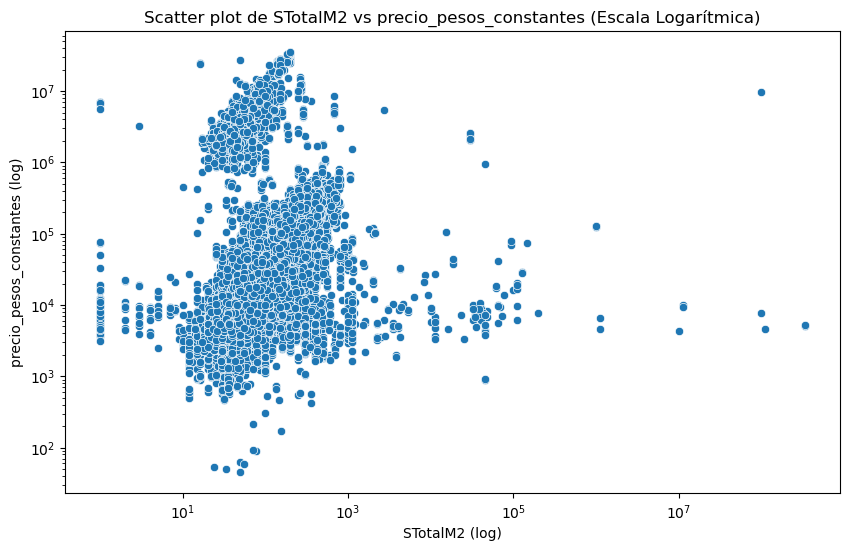

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Crear un scatter plot de precio_pesos_constantes y STotalM2 en escala logarítmica
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(x=train_procesado['STotalM2'], y=train_procesado['precio_pesos_constantes'])
scatter_plot.set(xscale="log", yscale="log")
plt.title('Scatter plot de STotalM2 vs precio_pesos_constantes (Escala Logarítmica)')
plt.xlabel('STotalM2 (log)')
plt.ylabel('precio_pesos_constantes (log)')
plt.show()

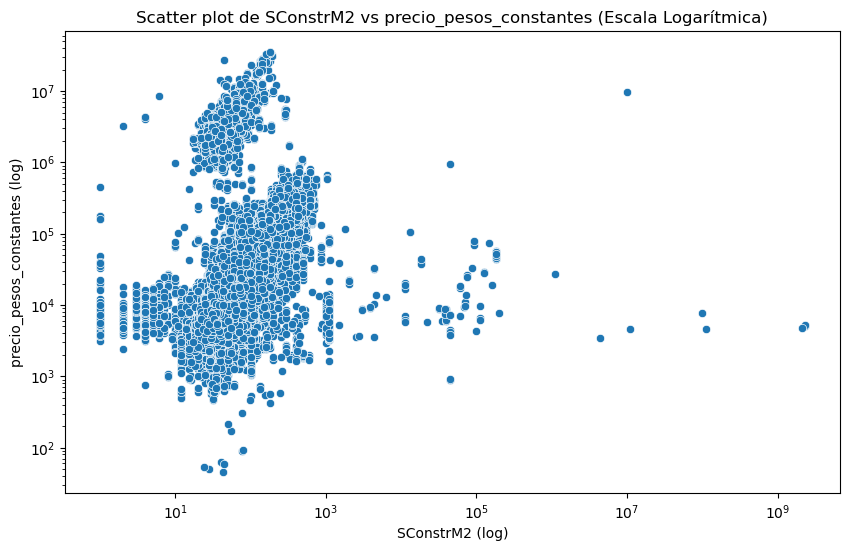

In [7]:
# Crear un scatter plot de precio_pesos_constantes y STotalM2 en escala logarítmica
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(x=train_procesado['SConstrM2'], y=train_procesado['precio_pesos_constantes'])
scatter_plot.set(xscale="log", yscale="log")
plt.title('Scatter plot de SConstrM2 vs precio_pesos_constantes (Escala Logarítmica)')
plt.xlabel('SConstrM2 (log)')
plt.ylabel('precio_pesos_constantes (log)')
plt.show()

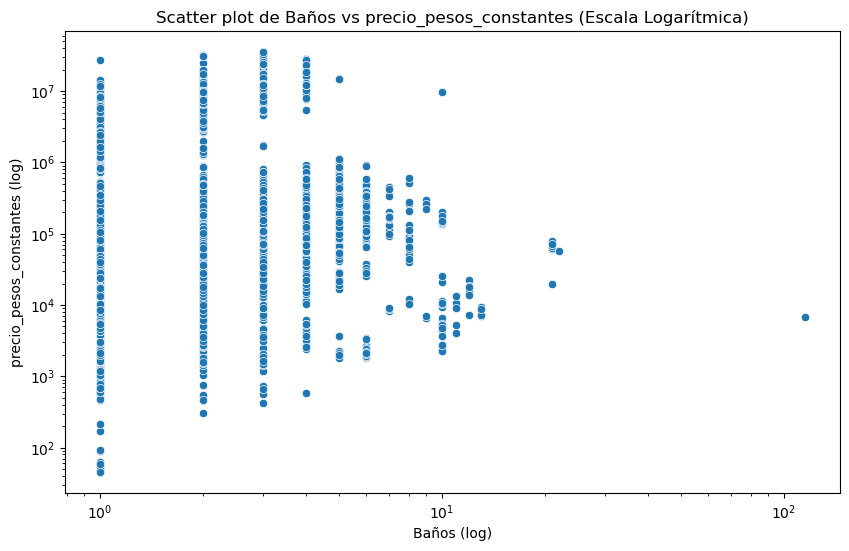

In [8]:
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(x=train_procesado['Banos'], y=train_procesado['precio_pesos_constantes'])
scatter_plot.set(xscale="log", yscale="log")
plt.title('Scatter plot de Baños vs precio_pesos_constantes (Escala Logarítmica)')
plt.xlabel('Baños (log)')
plt.ylabel('precio_pesos_constantes (log)')
plt.show()